In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import re
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from google.colab import drive
from google.colab.patches import cv2_imshow



In [52]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Make dataset

In [54]:
import os
import re
from pycocotools.coco import COCO

def extract_ids(image_folder:str, ann_file:str):
  """
    return final_ids which is in pic and ann file
    image_folder: path to the image folder
    ann_file: path to the annotation file
  """
  coco = COCO(ann_file)
  # List of ids in ann
  img_ids = coco.getImgIds()

  # path of images
  image_list = os.listdir(image_folder)
  id_list = []
  for image_name in image_list:
    if image_name.endswith(".jpg") or image_name.endswith(".jpeg"):
      # Extracting ID using regular expression
      match = re.search(r'\d+', image_name)
      if match:
        image_id = int(match.group())
        id_list.append(image_id)

  # Intersection of two list
  final_id = list(set(img_ids) & set(id_list))

  return final_id

def one_label_COCO(image_folder:str, ann_file:str):
  """
    return image id and uniq label (Select the class with the largest number of objects)
    image_folder: path to the image folder
    ann_file: path to the annotation file
  """
  # retirn final_ids which is in pic and ann file
  image_ids = extract_ids(image_folder, ann_file)
  # Define coco
  coco = COCO(ann_file)

  # Create a dictionary to store the final labels
  img_to_label = {}

  # Processing each image
  for img_id in image_ids:
      # Get image annotations
      ann_ids = coco.getAnnIds(imgIds=img_id)
      anns = coco.loadAnns(ann_ids)

      # Count the number of objects of each class
      class_counts = {}
      for ann in anns:
          class_id = ann['category_id']
          class_counts[class_id] = class_counts.get(class_id, 0) + 1

      # Select the class with the largest number of objects.
      if class_counts:
          dominant_class = max(class_counts, key=class_counts.get)
          img_to_label[img_id] = dominant_class
      else:
          img_to_label[img_id] = None  # If the image has no objects

  #Sort Dict by id
  img_to_label = dict(sorted(img_to_label.items()))

  return img_to_label

def onehot_labels(my_dict:dict, num_classes:int):
  """
  changes the dictionary which has id and classes to one hot array
  my_dict: main dictionary
  num_classes: number of classes
  """
  # Number of classes
  num_classes = num_classes
  # Create a 2D array of the form (number of data, num_classes)
  num_data = len(my_dict)
  onehot_array = np.zeros((num_data, num_classes))
  # Converting a dictionary to a one-hot two-dimensional array
  for idx, (key, val) in enumerate(my_dict.items()):
      onehot_array[idx][val] = 1
  return onehot_array

In [55]:

image_folder = "/content/drive/MyDrive/Ai_Lab/data/coco/pic"
ann_file = '/content/drive/MyDrive/Ai_Lab/data/coco/annotations_small/instances_val2017.json'
my_dicc = one_label_COCO(image_folder, ann_file)

my_dict = my_dicc
num_classes = 183
y_all=onehot_labels(my_dict, num_classes)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [57]:

def pic_preproc_Intersection(image_folder:str, ann_file:str, size: int):
  """
  resize and add 1 dimention to the image.  return just Intersection images.
  image_folder: path to the image folder
  ann_file: path to the annotation file
  size: size of Length and width
  """
  id_Intersection = extract_ids(image_folder, ann_file)
  # A list to save the paths of the desired images
  filtered_image_paths = []

  # Reading image paths
  image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]

  # Filter image paths based on IDs in id_Intersection
  for image_path in image_paths:
      image_name = os.path.basename(image_path)
      id_number = int(image_name.split('.')[0])  #Extracting ID from image name
      if id_number in id_Intersection:
          filtered_image_paths.append(image_path)  # Add image path to filtered list
  # Sort the path
  filtered_image_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
  print(filtered_image_paths)
  #####Preprocess function
  all_images = []
  # main function
  for img_path in filtered_image_paths:
      img = cv2.imread(img_path)
      gray_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(gray_img1, (size, size))
      gray_img2 = resized_img[:, :, np.newaxis]
      # Normalize pixel values to be between 0 and 1
      gray_img2 = gray_img2 / 255.0

      # Add processed image to list
      all_images.append(gray_img2)
  # Convert list to NumPy array
  all_pic = np.array(all_images)

  return all_pic


In [58]:
image_folder = "/content/drive/MyDrive/Ai_Lab/data/coco/pic"
ann_file = '/content/drive/MyDrive/Ai_Lab/data/coco/annotations_small/instances_val2017.json'
size = 200
x_all = pic_preproc_Intersection(image_folder, ann_file, size)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
['/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000139.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000285.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000000632.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002592.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002685.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000002923.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003156.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003255.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003501.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003553.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003661.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003845.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000003934.jpg', '/content/drive/MyDrive/Ai_Lab/data/coco/pic/000000004134.jpg', '/content/drive/MyDr

In [69]:
def train_test_splitt(x_all:np.ndarray, y_all:np.ndarray, test_ratio:float):
  """
  split train and test. for x and y
  x_all: x data (input pic)
  y_all: y data (label)
  test_ratio:  test ratio (float)
  """
  # Splitting the data into train and test with a ratio of 80 to 20 percent
  x_train, x_test, y_train, y_test,  = train_test_split(x_all,y_all, test_size=test_ratio , random_state=42)
  return x_train, x_test, y_train, y_test


In [70]:
x_al=x_all
y_al = y_all
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_splitt(x_al, y_al, test_ratio)


In [75]:
min_pixel_value = 0
max_pixel_value = 1
print ("min_pixel_value =" , min_pixel_value, "," , "max_pixel_value =" , max_pixel_value)
print ("x_train.shape =" , x_train.shape, "," , "y_train =" , y_train.shape)

min_pixel_value = 0 , max_pixel_value = 1
x_train.shape = (37, 200, 200, 1) , y_train = (37, 183)


# Models

In [73]:
pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.7 MB/s eta 0:00:00


In [74]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()  # Added to prevent Tensorflow execution error

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowClassifier
from art.utils import load_mnist

In [77]:
# Step 2: Create the model

input_ph = tf.placeholder(tf.float32, shape=[None, 200, 200, 1])
labels_ph = tf.placeholder(tf.int32, shape=[None, 183])
print ("input_ph.shape =" , input_ph.shape)

input_ph.shape = (None, 200, 200, 1)


In [78]:
# Step 2: Create the model

x = tf.keras.layers.Conv2D(filters=4, kernel_size=5, activation=tf.nn.relu)(input_ph)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(filters=10, kernel_size=5, activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
logits = tf.keras.layers.Dense(183)(x)

loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels_ph))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [79]:
# Step 3: Create the ART classifier

classifier = TensorFlowClassifier(
    clip_values=(min_pixel_value, max_pixel_value),
    input_ph=input_ph,
    output=logits,
    labels_ph=labels_ph,
    train=train,
    loss=loss,
    learning=None,
    sess=sess,
    preprocessing_defences=[],
)

In [80]:
# Step 4: Train the ART classifier

history = classifier.fit(x_train, y_train, batch_size=3, nb_epochs=5)

In [81]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print ("y_test =" , y_test.shape, "," , "predictions =" , predictions.shape)

Accuracy on benign test examples: 70.0%
y_test = (10, 183) , predictions = (10, 183)


In [112]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=100)
x_test_adv = attack.generate(x=x_test)
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 70.0%


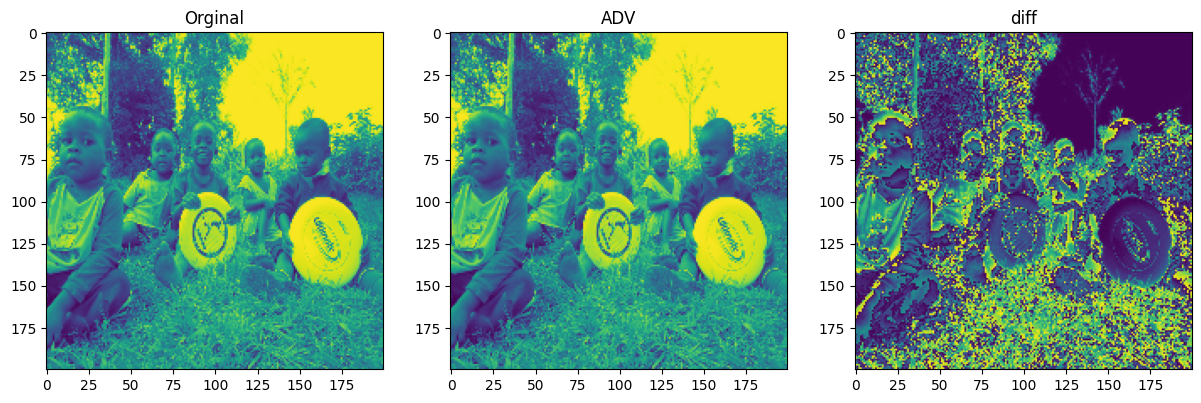

In [114]:
r_x_test= x_test.reshape(10,200,200)
r_x_test_adv = x_test_adv.reshape(10,200,200)

diff_image = np.abs(r_x_test[1,] - r_x_test_adv[1,])  # Absolute pixel difference

plt.figure(figsize=[20,5])
plt.subplot(141);plt.imshow(r_x_test[1,]);plt.title("Orginal");
plt.subplot(142);plt.imshow(r_x_test_adv[1,]);plt.title("ADV");
plt.subplot(143);plt.imshow(diff_image);plt.title("diff");
